<a href="https://colab.research.google.com/github/santiagorc99/AnaliticaDatos/blob/master/main_people_Santiago_Rincon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analítica de datos - ejemplo de clase lfw_people - comparación distintos métodos de clasificación - Ejecución sobre Google Colaboratory

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación

Nota: conjunto de evaluación no se utiliza en NINGUNA etapa de entrenamiento 

# Se declaran las funciones principales a utilizar sobre el cuaderno
# también se puede generar un archivo .py desde su Google drive (ver celda principal de carga de datos en este cuaderno)

Para este caso se importa la librería con las funciones desde google drive, no se utilizan las funciones que estáán en la primera celda de cóódigo, por ello, esta celda estáá totalmente comentada.

In [1]:
''' 
import os
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#%% Analisis exploratorio basico - base de datos housing
def pre_exploratorio(Xtrain_pre,ytrain_pre,path_img,col_sal,w,h,Np=None):
    #exploratorio basico -> Normalizar + reduccion de dimensionalidad
    normalizar = StandardScaler()
    #escoger aleatoriamente puntos para evitar costo computacional - analisis inicial
    if Np == None: Np = len(Xtrain_pre.index)
    
    ind = np.random.randint(0,len(Xtrain_pre.index),Np) #escoger subconjunto de datos
    
    Xz = normalizar.fit_transform(Xtrain_pre.iloc[ind,:])
    yc = ytrain_pre[ind].reshape(-1)
    
    #reduccion de dimension con pca y tsne
    red_pca = PCA()
    perplexity = np.round(0.75*np.sqrt(Np))
    red_tsne = TSNE(n_components=2,perplexity = perplexity, n_iter = 250,verbose = 10)
        
    Xred_pca = pd.DataFrame(red_pca.fit_transform(Xz))
    Xred_tsne = pd.DataFrame(red_tsne.fit_transform(Xz))
  
    #Relevancia por variabilidad
    var_ret = 0.95
    rel_vec,Mv,ind_rel = rel_pca(red_pca,var_ret)
    
    #graficar
    sval = 30
    #pca 2D
    Xred_pca.plot(kind="scatter",x=0,y=1,
               c = yc, s=sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('PCA 2D')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    save_fig(path_img,"red_PCA2D")
    plt.show()
    
    #relevancia pca 2D     
    plt.imshow(rel_vec.reshape(w,h),cmap='jet')
    plt.ylabel('Relevancia PCA - eigenfaces')
    plt.title('RELEVANCIA PCA - eigenfaces, var_ret=%.2f' % (var_ret))
    plt.colorbar()
    save_fig(path_img,"relevancia_PCA_eigenface")
    plt.show()
    #tsne 2D
    Xred_tsne.plot(kind="scatter",x=0,y=1,
               c = yc, s = sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('t-sne 2D - Perp.=%.2f' % perplexity)
    plt.xlabel('Embebimiento - Dim. 1')
    plt.ylabel('Embebimiento - Dim. 2')
    save_fig(path_img,"tsne_2D")
    plt.show()
    
    return True
#%% relevancia por variabilidad con pca
def rel_pca(red,var_exp):
    Mv = np.min(np.where(np.cumsum(red.explained_variance_ratio_)
                         >var_exp))
    M,P = red.components_.shape
    #print(P,M)
    rel_vec = np.zeros((P))
    for i in range(Mv):
        #print(i)
        rel_vec += abs(red.explained_variance_ratio_[i]*red.components_[i,:])
    
    rel_vec = rel_vec/sum(rel_vec)
    rel_vec = rel_vec - min(rel_vec)
    rel_vec = rel_vec/max(rel_vec)
    
    ind_rel = rel_vec.argsort()[::-1]
    return rel_vec, Mv,ind_rel

#%%  guardar figuras
from google.colab import files
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path) 

def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):   
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))

    save_fig(path_img,title)
    plt.show()

    
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
'''

' \nimport os\nfrom sklearn.impute import SimpleImputer \nfrom sklearn.preprocessing import OrdinalEncoder,OneHotEncoder\nfrom sklearn.base import  BaseEstimator, TransformerMixin\nimport pandas as pd\nimport numpy as np\nfrom sklearn.decomposition import PCA \nfrom sklearn.manifold import TSNE\nfrom sklearn.preprocessing import StandardScaler\nimport matplotlib.pyplot as plt\nimport warnings\nwarnings.filterwarnings("ignore")\n#%% Analisis exploratorio basico - base de datos housing\ndef pre_exploratorio(Xtrain_pre,ytrain_pre,path_img,col_sal,w,h,Np=None):\n    #exploratorio basico -> Normalizar + reduccion de dimensionalidad\n    normalizar = StandardScaler()\n    #escoger aleatoriamente puntos para evitar costo computacional - analisis inicial\n    if Np == None: Np = len(Xtrain_pre.index)\n    \n    ind = np.random.randint(0,len(Xtrain_pre.index),Np) #escoger subconjunto de datos\n    \n    Xz = normalizar.fit_transform(Xtrain_pre.iloc[ind,:])\n    yc = ytrain_pre[ind].reshape(-1)\

In [0]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#para acceder a archivos desde google drive en google colaboratory
#acceso a google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#
file_id = '1dnaEfWjgTYzyZLMtyr8f142b_3eTikif' #copiar nombre nombre del link de compartir despues de ID
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('funciones_people.py') 
from funciones_people import pre_exploratorio, save_fig, plot_confusion_matrix, roc_multiclass, roc_auc_mc

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

#ejemplo imagen en base de datos
#print('Dimensiones base de datos: \n',lfw_people.images.shape)
#plt.imshow(lfw_people.images[30,:,:],cmap='gray')

#print('Clases base de datos: \n',lfw_people['target_names'])
#print(lfw_people.images[30,:,:])

Dimensiones tipo pandas:  (1288, 1850)


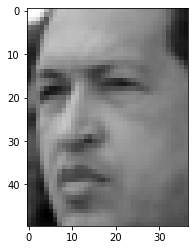

In [3]:
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
plt.imshow(np.array(Xdata.iloc[0,:]).reshape(lfw_people.images.shape[1],lfw_people.images.shape[2]),cmap='gray')


In [4]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3) #fijar en 0.3 para entrenar -- 0.95 para demostrar funcionalidad del código

Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
202,72.333336,103.666664,170.666672,189.000000,177.333328,199.666672,216.000000,221.000000,221.666672,219.000000,218.333328,220.666672,220.666672,218.666672,221.666672,220.666672,220.333328,222.000000,221.333328,219.666672,219.333328,215.000000,210.666672,212.000000,212.666672,211.666672,204.333328,199.000000,200.666672,199.000000,198.000000,200.666672,203.000000,188.000000,168.333328,170.000000,163.333328,68.666664,120.666664,183.333328,...,124.000000,127.333336,139.666672,109.000000,118.333336,130.000000,69.000000,35.000000,37.000000,32.333332,27.000000,28.333334,69.333336,174.000000,205.000000,207.000000,205.666672,202.000000,196.000000,182.333328,172.000000,168.666672,160.000000,154.333328,144.666672,145.666672,149.333328,154.000000,163.333328,164.333328,165.666672,164.333328,158.333328,146.000000,133.666672,123.333336,116.333336,117.666664,127.666664,141.666672
316,91.333336,108.000000,114.000000,111.333336,108.666664,108.000000,109.000000,108.666664,105.000000,114.333336,131.333328,141.333328,145.666672,146.666672,147.333328,151.000000,156.666672,158.333328,156.000000,154.666672,152.666672,147.333328,144.000000,143.333328,140.666672,137.666672,135.333328,135.666672,133.666672,128.333328,125.333336,121.333336,114.333336,103.333336,84.333336,71.333336,63.333332,101.000000,113.666664,117.666664,...,31.333334,26.000000,26.333334,30.333334,30.333334,30.333334,29.666666,28.333334,28.000000,28.000000,28.666666,26.666666,57.666668,175.666672,174.666672,119.666664,105.333336,115.333336,123.666664,127.333336,125.000000,119.666664,125.000000,132.333328,133.666672,128.333328,116.333336,134.666672,167.333328,174.333328,154.333328,130.666672,66.666664,35.666668,31.333334,29.000000,29.333334,28.666666,28.333334,30.333334
1210,138.000000,144.666672,151.666672,154.000000,154.666672,156.666672,159.333328,161.666672,165.333328,167.666672,167.333328,166.000000,167.333328,170.666672,169.666672,166.666672,167.000000,164.666672,165.000000,164.333328,161.000000,157.000000,154.333328,152.666672,151.666672,148.666672,147.333328,144.000000,139.333328,133.333328,123.666664,117.333336,125.000000,141.333328,124.000000,98.000000,91.333336,140.666672,150.666672,158.000000,...,24.333334,22.666666,19.333334,26.666666,67.333336,154.666672,150.333328,110.000000,87.000000,84.666664,97.666664,107.666664,107.333336,104.666664,103.000000,93.666664,95.333336,105.333336,111.000000,111.666664,114.333336,116.666664,120.333336,124.000000,123.666664,118.666664,109.333336,108.666664,109.666664,106.000000,117.333336,157.000000,206.000000,227.000000,211.333328,140.333328,52.333332,21.333334,24.000000,20.333334
1077,153.666672,136.666672,135.000000,135.666672,136.333328,149.000000,153.333328,149.666672,153.333328,158.333328,161.666672,166.666672,173.666672,177.333328,168.000000,167.333328,168.000000,170.666672,166.666672,160.666672,157.666672,154.000000,149.000000,144.666672,137.000000,130.333328,123.666664,124.666664,123.333336,117.333336,107.333336,98.666664,84.000000,69.333336,58.000000,59.000000,76.000000,149.000000,145.000000,145.000000,...,39.000000,8.333333,9.000000,49.000000,71.666664,186.000000,241.000000,245.333328,243.666672,242.333328,237.666672,213.000000,175.333328,151.000000,144.666672,147.333328,147.333328,154.333328,161.000000,168.333328,174.333328,173.000000,170.666672,162.000000,154.333328,149.666672,141.333328,121.333336,93.000000,64.000000,46.666668,45.333332,66.333336,106.000000,129.333328,134.666672,112.333336,34.666668,10.666667,8.333333
149,55.666668,66.333336,99.000000,108.000000,107.666664,111.000000,119.000000,129.000000,136.666672,143.333328,158.333328,164.333328,168.333328,170.333328,169.666672,170.666672,173.333328,175.666672,179.

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 901 samples in 0.168s...
[t-SNE] Computed neighbors for 901 samples in 3.255s...
[t-SNE] Computed conditional probabilities for sample 901 / 901
[t-SNE] Mean sigma: 14.025264
[t-SNE] Computed conditional probabilities in 0.052s
[t-SNE] Iteration 50: error = 74.6564636, gradient norm = 0.3543315 (50 iterations in 0.426s)
[t-SNE] Iteration 100: error = 74.0441818, gradient norm = 0.3359267 (50 iterations in 0.396s)
[t-SNE] Iteration 150: error = 73.9109650, gradient norm = 0.3403639 (50 iterations in 0.401s)
[t-SNE] Iteration 200: error = 74.0951691, gradient norm = 0.3560388 (50 iterations in 0.469s)
[t-SNE] Iteration 250: error = 74.6161118, gradient norm = 0.3432926 (50 iterations in 0.398s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.616112
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781715404589535143824

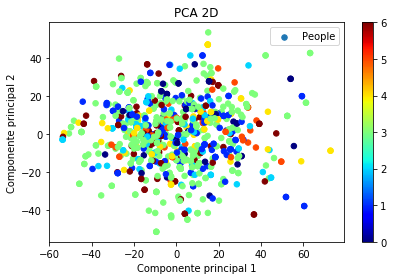

Guardando... relevancia_PCA_eigenface


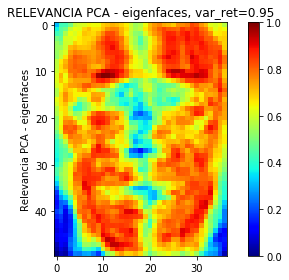

Guardando... tsne_2D


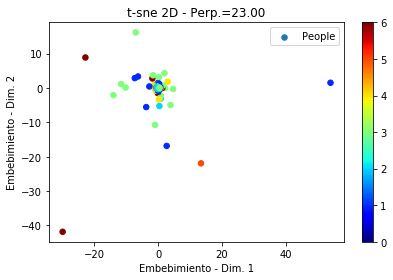

True

In [5]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = '' #para guardar from google.colab import files plt.savefig("abc.png") files.download("abc.png") 
pre_exploratorio(Xtrain,ytrain,img_path,'People',lfw_people.images.shape[1],lfw_people.images.shape[2])

In [6]:
#%% Paso 4 : Escoger modelo por RandomsearchCV utilizando pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/
from sklearn.model_selection import RandomizedSearchCV

steps=[[('cla',LogisticRegression())],
       [('cla',SGDClassifier())],
       [('cla',SVC())],# vecinos knn, c log
       [('cla',RandomForestClassifier())],
       [('cla',KNeighborsClassifier())],
       [('cla',GaussianNB())],
       [('rep',PCA()),
        ('cla',LogisticRegression())],
       [('rep',PCA()),
        ('cla',SGDClassifier())],
       [('rep',PCA()),
        ('cla',SVC())],
       [('rep',PCA()),
        ('cla',RandomForestClassifier())],
       [('rep',PCA()),
        ('cla',KNeighborsClassifier())],
       [('rep',PCA()),
        ('cla',GaussianNB())]
      ]  #LR->C, SGD->alpha, SVC-> C,gamma, KNN->Vecinos

parameters = [{ 'cla__C': np.linspace(0.1,1,10)},
              {'cla__alpha': np.linspace(0.1,1,10)},
              {'cla__C': np.linspace(0.1,1000,10),
               'cla__gamma': np.linspace(0.1,1000,10)},
              {'cla__n_estimators': [5,25,50,100,200],
               'cla__max_depth' : [1,2,3]},
              {'cla__n_neighbors': [1,3,5,7,9]},
              {'cla__var_smoothing': [1e-9]},
              { 'rep__n_components' : np.linspace(0.1,0.9,10),
               'cla__C': np.linspace(0.1,1,10)},
              {'rep__n_components' : np.linspace(0.1,0.9,10),
               'cla__alpha': np.linspace(0.1,1,10)},
              {'rep__n_components' : np.linspace(0.1,0.9,10),
               'cla__C': np.linspace(0.1,1000,10),
               'cla__gamma': np.linspace(0.1,1000,10)},
              {'rep__n_components' : np.linspace(0.1,0.9,10),
               'cla__n_estimators': [5,25,50,100,200],
               'cla__max_depth' : [1,2,3]},
              {'rep__n_components' : np.linspace(0.1,0.9,10),
               'cla__n_neighbors': [1,3,5,7,9]},
              {'rep__n_components' : np.linspace(0.1,0.9,10)}            
]



label_models = ['Logistic', 'SGD', 'SVC', 'Random_Forest','KNN','NB',
                'PCA_Logistic', 'PCA_SGD', 'PCA_SVC', 'PCA_Random_Forest'
                ,'PCA_KNN','PCA_NB',]
                

best_model = []
filename = ''#'resultados/people_comp'

for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    random_search = RandomizedSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    random_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    best_model += [random_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

modelo 1/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.0s finished


modelo 2/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.6s finished


modelo 3/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


modelo 4/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


modelo 5/12
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


modelo 6/12
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0697s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s


modelo 7/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.8s finished


modelo 8/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.9s finished


modelo 9/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.0s finished


modelo 10/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.1s finished


modelo 11/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.0s finished


modelo 12/12
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.8s finished


Mejores modelos:



[Pipeline(memory=None,
          steps=[('cla',
                  LogisticRegression(C=0.6, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('cla',
                  SGDClassifier(alpha=0.8, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.0,
                                fit_intercept=True, l1_ratio=0.15,
                                learning_rate='optimal', loss='hinge',
                                max_iter=1000, n_iter_no_change=5, n_jobs=None,
              

# Calcular rendimiento en cojunto de test

Evaluando modelo 1/12
Guardando... Logistic


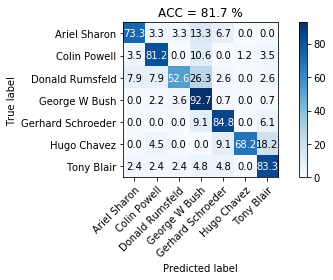

                   precision    recall  f1-score   support

     Ariel Sharon       0.76      0.73      0.75        30
     Colin Powell       0.88      0.81      0.85        85
  Donald Rumsfeld       0.74      0.53      0.62        38
    George W Bush       0.82      0.93      0.87       137
Gerhard Schroeder       0.78      0.85      0.81        33
      Hugo Chavez       0.94      0.68      0.79        22
       Tony Blair       0.76      0.83      0.80        42

         accuracy                           0.82       387
        macro avg       0.81      0.77      0.78       387
     weighted avg       0.82      0.82      0.81       387

Evaluando modelo 2/12
Guardando... SGD


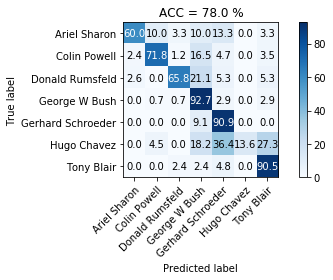

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.60      0.71        30
     Colin Powell       0.92      0.72      0.81        85
  Donald Rumsfeld       0.86      0.66      0.75        38
    George W Bush       0.79      0.93      0.86       137
Gerhard Schroeder       0.56      0.91      0.69        33
      Hugo Chavez       1.00      0.14      0.24        22
       Tony Blair       0.70      0.90      0.79        42

         accuracy                           0.78       387
        macro avg       0.81      0.69      0.69       387
     weighted avg       0.82      0.78      0.77       387

Evaluando modelo 3/12
Guardando... SVC


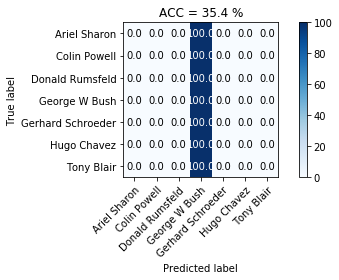

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        30
     Colin Powell       0.00      0.00      0.00        85
  Donald Rumsfeld       0.00      0.00      0.00        38
    George W Bush       0.35      1.00      0.52       137
Gerhard Schroeder       0.00      0.00      0.00        33
      Hugo Chavez       0.00      0.00      0.00        22
       Tony Blair       0.00      0.00      0.00        42

         accuracy                           0.35       387
        macro avg       0.05      0.14      0.07       387
     weighted avg       0.13      0.35      0.19       387

Evaluando modelo 4/12
Guardando... Random_Forest


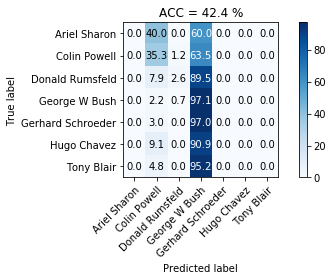

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        30
     Colin Powell       0.57      0.35      0.43        85
  Donald Rumsfeld       0.33      0.03      0.05        38
    George W Bush       0.40      0.97      0.57       137
Gerhard Schroeder       0.00      0.00      0.00        33
      Hugo Chavez       0.00      0.00      0.00        22
       Tony Blair       0.00      0.00      0.00        42

         accuracy                           0.42       387
        macro avg       0.19      0.19      0.15       387
     weighted avg       0.30      0.42      0.30       387

Evaluando modelo 5/12
Guardando... KNN


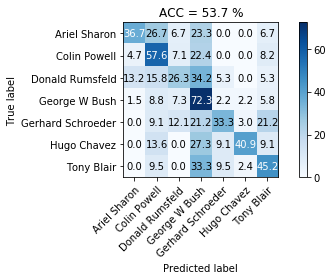

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.37      0.42        30
     Colin Powell       0.58      0.58      0.58        85
  Donald Rumsfeld       0.31      0.26      0.29        38
    George W Bush       0.60      0.72      0.66       137
Gerhard Schroeder       0.50      0.33      0.40        33
      Hugo Chavez       0.64      0.41      0.50        22
       Tony Blair       0.40      0.45      0.43        42

         accuracy                           0.54       387
        macro avg       0.51      0.45      0.47       387
     weighted avg       0.53      0.54      0.53       387

Evaluando modelo 6/12
Guardando... NB


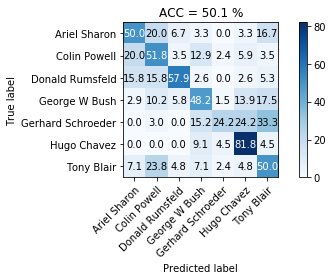

                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.50      0.40        30
     Colin Powell       0.54      0.52      0.53        85
  Donald Rumsfeld       0.59      0.58      0.59        38
    George W Bush       0.74      0.48      0.58       137
Gerhard Schroeder       0.57      0.24      0.34        33
      Hugo Chavez       0.33      0.82      0.47        22
       Tony Blair       0.31      0.50      0.39        42

         accuracy                           0.50       387
        macro avg       0.49      0.52      0.47       387
     weighted avg       0.57      0.50      0.51       387

Evaluando modelo 7/12
Guardando... PCA_Logistic


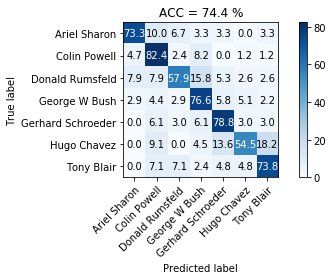

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.73      0.70        30
     Colin Powell       0.79      0.82      0.80        85
  Donald Rumsfeld       0.65      0.58      0.61        38
    George W Bush       0.85      0.77      0.81       137
Gerhard Schroeder       0.62      0.79      0.69        33
      Hugo Chavez       0.50      0.55      0.52        22
       Tony Blair       0.74      0.74      0.74        42

         accuracy                           0.74       387
        macro avg       0.69      0.71      0.70       387
     weighted avg       0.75      0.74      0.75       387

Evaluando modelo 8/12
Guardando... PCA_SGD


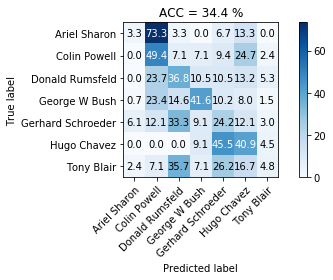

                   precision    recall  f1-score   support

     Ariel Sharon       0.20      0.03      0.06        30
     Colin Powell       0.38      0.49      0.43        85
  Donald Rumsfeld       0.21      0.37      0.27        38
    George W Bush       0.76      0.42      0.54       137
Gerhard Schroeder       0.14      0.24      0.18        33
      Hugo Chavez       0.15      0.41      0.22        22
       Tony Blair       0.20      0.05      0.08        42

         accuracy                           0.34       387
        macro avg       0.29      0.29      0.25       387
     weighted avg       0.43      0.34      0.35       387

Evaluando modelo 9/12
Guardando... PCA_SVC


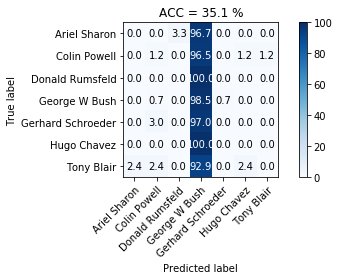

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        30
     Colin Powell       0.25      0.01      0.02        85
  Donald Rumsfeld       0.00      0.00      0.00        38
    George W Bush       0.36      0.99      0.53       137
Gerhard Schroeder       0.00      0.00      0.00        33
      Hugo Chavez       0.00      0.00      0.00        22
       Tony Blair       0.00      0.00      0.00        42

         accuracy                           0.35       387
        macro avg       0.09      0.14      0.08       387
     weighted avg       0.18      0.35      0.19       387

Evaluando modelo 10/12
Guardando... PCA_Random_Forest


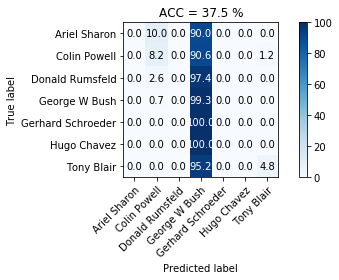

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        30
     Colin Powell       0.58      0.08      0.14        85
  Donald Rumsfeld       0.00      0.00      0.00        38
    George W Bush       0.37      0.99      0.53       137
Gerhard Schroeder       0.00      0.00      0.00        33
      Hugo Chavez       0.00      0.00      0.00        22
       Tony Blair       0.67      0.05      0.09        42

         accuracy                           0.37       387
        macro avg       0.23      0.16      0.11       387
     weighted avg       0.33      0.37      0.23       387

Evaluando modelo 11/12
Guardando... PCA_KNN


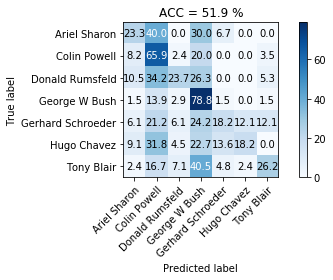

                   precision    recall  f1-score   support

     Ariel Sharon       0.28      0.23      0.25        30
     Colin Powell       0.46      0.66      0.54        85
  Donald Rumsfeld       0.43      0.24      0.31        38
    George W Bush       0.62      0.79      0.69       137
Gerhard Schroeder       0.40      0.18      0.25        33
      Hugo Chavez       0.44      0.18      0.26        22
       Tony Blair       0.50      0.26      0.34        42

         accuracy                           0.52       387
        macro avg       0.45      0.36      0.38       387
     weighted avg       0.50      0.52      0.49       387

Evaluando modelo 12/12
Guardando... PCA_NB


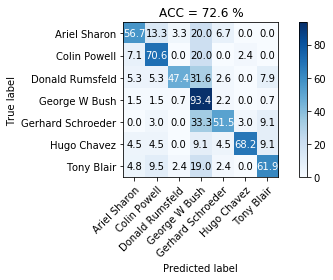

                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.57      0.57        30
     Colin Powell       0.81      0.71      0.75        85
  Donald Rumsfeld       0.86      0.47      0.61        38
    George W Bush       0.70      0.93      0.80       137
Gerhard Schroeder       0.68      0.52      0.59        33
      Hugo Chavez       0.83      0.68      0.75        22
       Tony Blair       0.74      0.62      0.68        42

         accuracy                           0.73       387
        macro avg       0.74      0.64      0.68       387
     weighted avg       0.74      0.73      0.72       387



In [7]:
#%% Paso 5: evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

Evaluando ROC modelo 1/12
Guardando... ROC curve Logistic


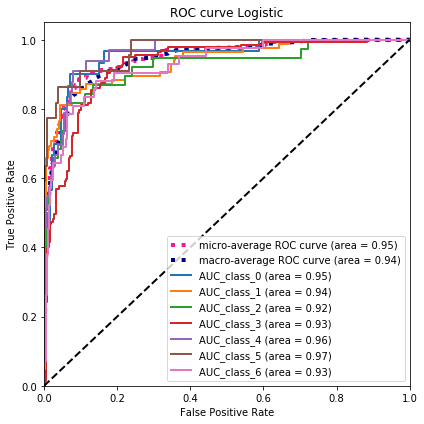

Evaluando ROC modelo 2/12
Guardando... ROC curve SGD


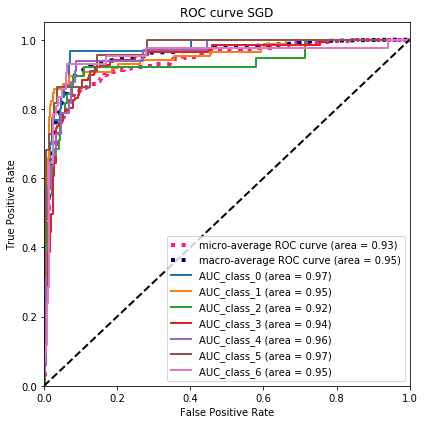

Evaluando ROC modelo 3/12
Guardando... ROC curve SVC


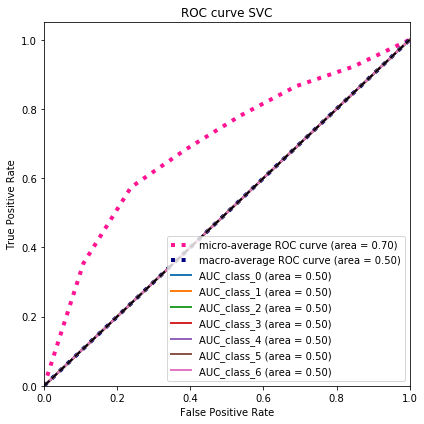

Evaluando ROC modelo 4/12
Guardando... ROC curve Random_Forest


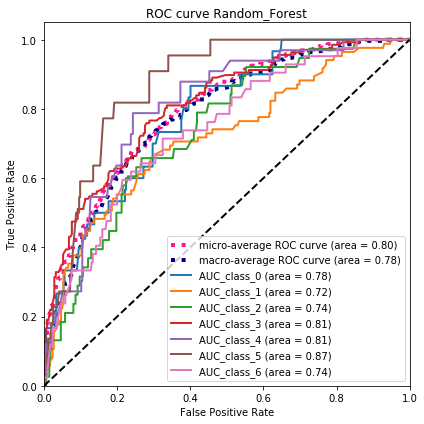

Evaluando ROC modelo 5/12
Guardando... ROC curve KNN


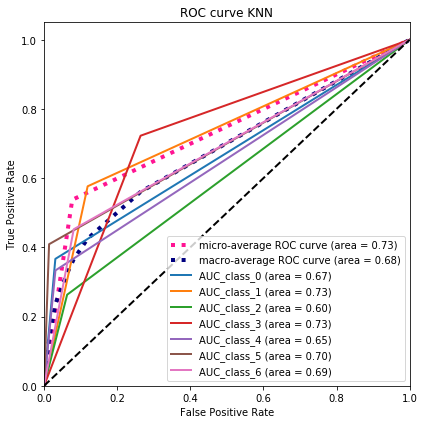

Evaluando ROC modelo 6/12
Guardando... ROC curve NB


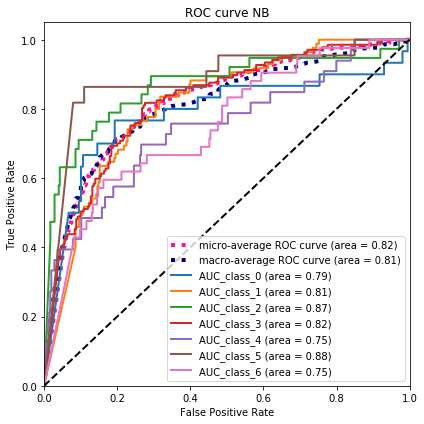

Evaluando ROC modelo 7/12
Guardando... ROC curve PCA_Logistic


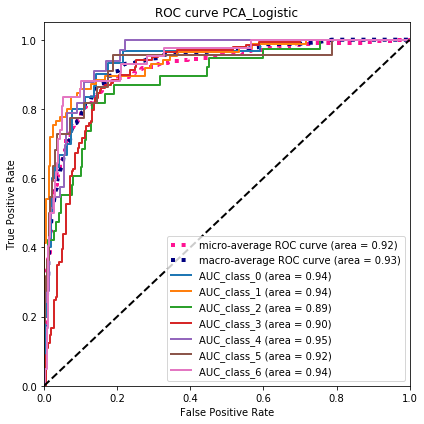

Evaluando ROC modelo 8/12
Guardando... ROC curve PCA_SGD


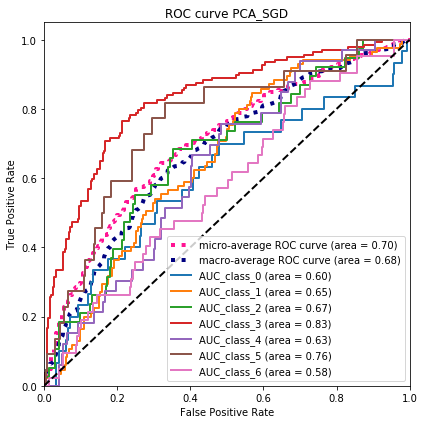

Evaluando ROC modelo 9/12
Guardando... ROC curve PCA_SVC


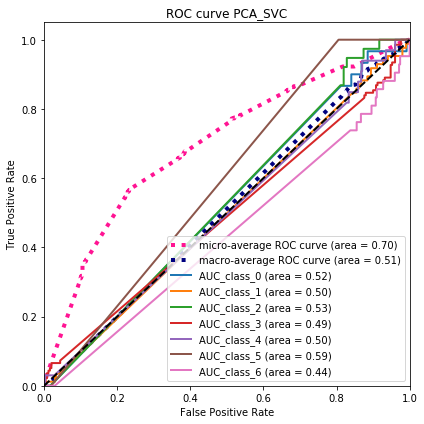

Evaluando ROC modelo 10/12
Guardando... ROC curve PCA_Random_Forest


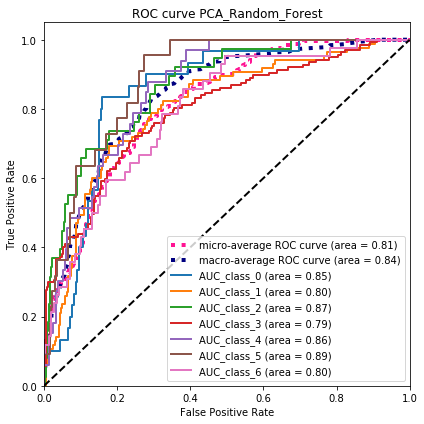

Evaluando ROC modelo 11/12
Guardando... ROC curve PCA_KNN


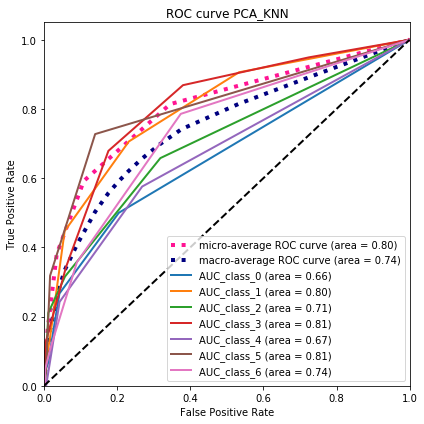

Evaluando ROC modelo 12/12
Guardando... ROC curve PCA_NB


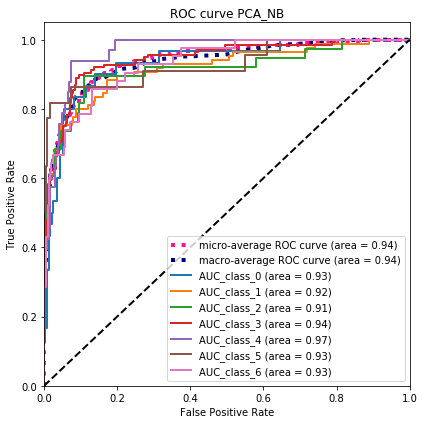

In [8]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded)))
    try:
        ytest_score = my_model_loaded[i].decision_function(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
    except AttributeError:
        ytest_score = my_model_loaded[i].predict_proba(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
        
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    